# WEEK1 - HOMEWORK1
## 과제 내용
- (1) 두 가지 키워드로 크롤링을 수행하여 이미지 자료를 모아라. (키워드는 각자 마음에 드는 것으로 설정할 것, 단 (iu,hynn)는 제외)
- (2) ImageDataLoaders.from_folder() 를 이용하여 dls를 만들고 dls.show_batch()를 이용하여 만들어진 이미지를 확인하라.
- (3) vision_learner()를 이용하여 lrnr를 만들고 lrnr.fine_tune()을 이용하여 학습하라. 이때 모형의 arch는 resnet34를 사용하라.
- (4) requests.get()을 이용하여 (1)의 키워드에 해당하는 새로운 이미지를 한장씩 다운받고 (3)에서 학습한 lrnr를 이용하여 예측하라.

### STEP1 두 가지 키워드로 크롤링을 수행하여 이미지 자료를 모아라.

In [4]:
from duckduckgo_search import DDGS

def search_images(keyword, max_images=200):
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(
            keyword,
            max_results=max_images,
        )
        results = [r for r in ddgs_images_gen]
    image_sources = [r['image'] for r in results]
    return image_sources

In [ ]:
import urllib.request
import os

def download_images(dest, urls):
    # Create the directory if it doesn't exist
    if not os.path.exists(dest):
        os.makedirs(dest)

    # Download and save each image
    for i, url in enumerate(urls):
        try:
            urllib.request.urlretrieve(url, f'{dest}/img_{i}.jpg')
        except Exception as e:
            print(f"Error downloading image {url}: {e}")

download_images(dest='./images/train/burger', urls=search_images('burger', max_images=200))
download_images(dest='./images/train/sandwich', urls=search_images('sandwich', max_images=200))

### STEP2 -- dls 생성 및 batch 확인

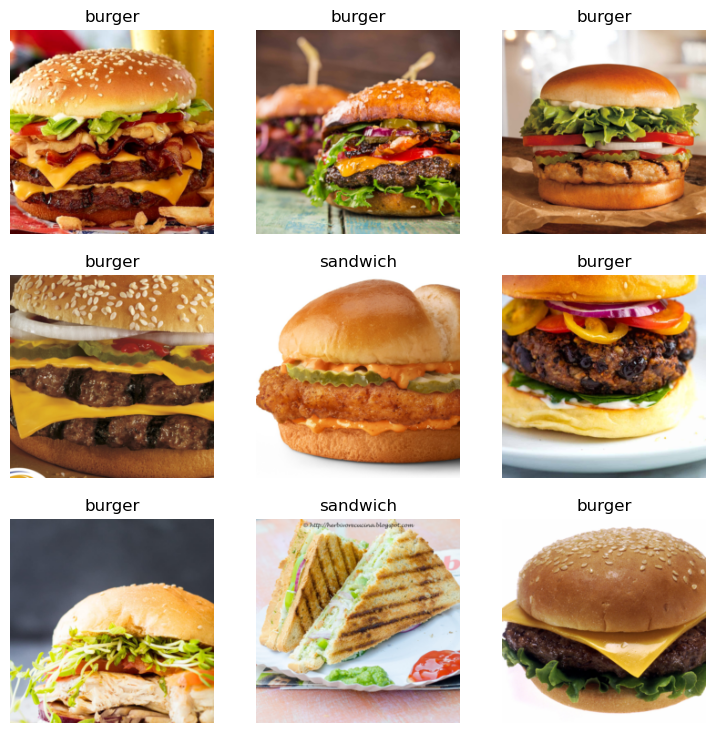

In [6]:

from fastai.vision.all import *

# Define your path to the directory with images
path = Path('images')

bad_images = verify_images(get_image_files('./images'))
bad_images.map(Path.unlink)

# Create a DataLoaders object
dls = ImageDataLoaders.from_folder(
    path = './images',
    train='train',
    valid_pct = 0.2,
    item_tfms=Resize(224),
)

# Show a batch of images
dls.show_batch()

### STEP3 -- vision_learner 생성 미치 학습; arch==resnet34

epoch,train_loss,valid_loss,accuracy,time
0,1.042725,0.565457,0.812500,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.793348,0.239411,0.875000,00:11
1,0.623745,0.133719,0.958333,00:11
2,0.496901,0.090282,0.979167,00:11
3,0.397802,0.060520,0.979167,00:11
4,0.320169,0.056794,0.979167,00:11
5,0.270389,0.062767,0.979167,00:11
6,0.230151,0.066524,0.979167,00:11


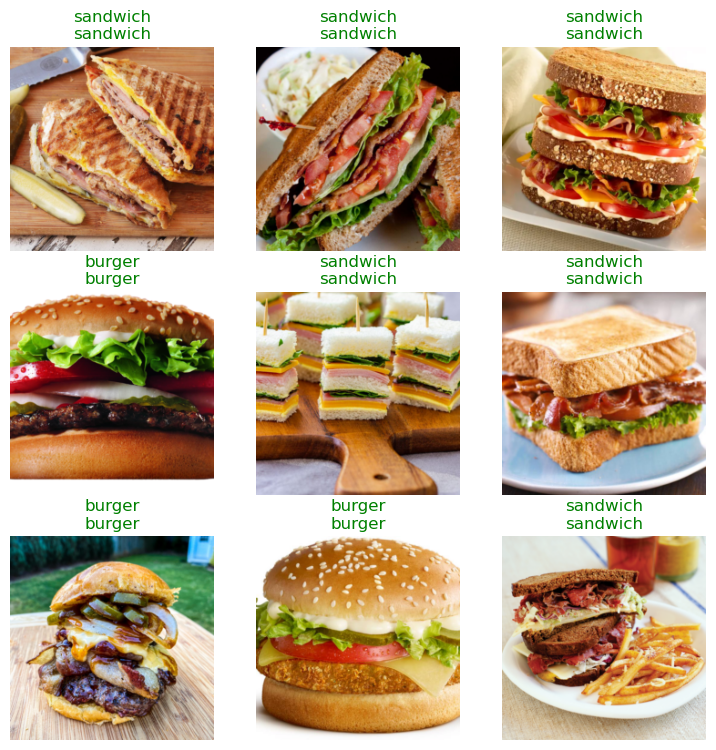

In [8]:

lrnr = vision_learner(
    dls = dls,
    arch = resnet34,
    metrics = accuracy
)

lrnr.fine_tune(7)
lrnr.show_results()

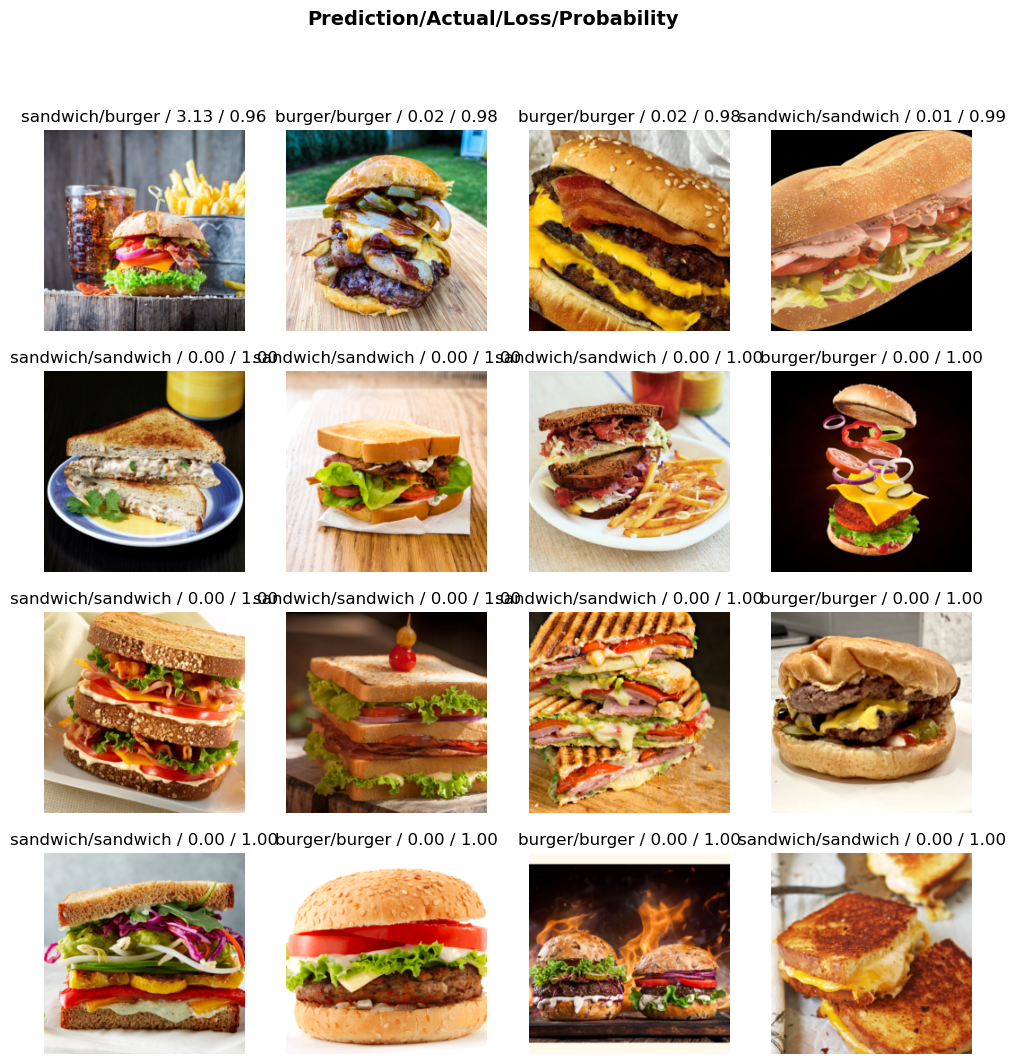

In [10]:
inter = Interpretation.from_learner(lrnr)
inter.plot_top_losses(16) # 오답을 분석하는 오브젝트는 가장 오류가 높은 이미지를 정렬하여 보여주는 기능이 있음..

### STEP4 -- 새로운 이미지를 다운로드 and predict

('sandwich', tensor(1), tensor([0.0041, 0.9959]))

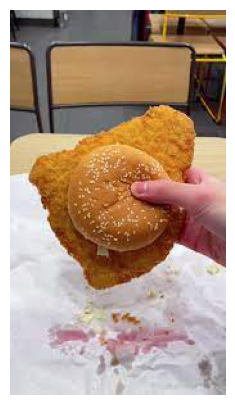

In [19]:
import requests

### Burger -- 롯데리아 신메뉴 왕 돈가스버거
new_burger = PILImage.create(
    requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRaV2TiZkCjjep72hLyH2kJllGDNkFXDIXBwowgQ_QDtGNdmw1qB-ECF6T5jVJsQ2CoBhw&usqp=CAU?raw=true').content)
new_burger.show()
lrnr.predict(new_burger) # 틀림.

('sandwich', tensor(1), tensor([8.8780e-05, 9.9991e-01]))

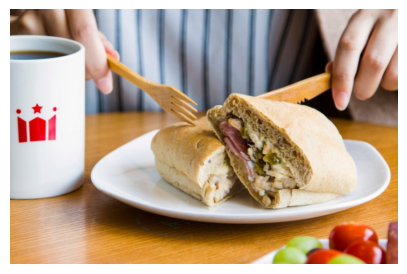

In [23]:
### Sandwich -- 할리스 커피 샌드위치
new_sandwich = PILImage.create(
    requests.get('https://cliimage.commutil.kr/phpwas/restmb_allidxmake.php?pp=002&idx=3&simg=2018031409264706591204ead07911751983028.jpg&nmt=12').content)
new_sandwich.show()
lrnr.predict(new_sandwich)  # 맞음.